In [1]:
%matplotlib inline
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import skimage
import torch
import nibabel as nib

from totalsegmentator.python_api import totalsegmentator
from totalsegmentator.libs import combine_masks

import pygalmesh
import meshio

sys.path.append('..')
import project

torch.cuda.is_available()

True

In [17]:
%autoreload
data_root = '/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene'
dataset = project.copdgene.COPDGene(data_root)
dataset

COPDGene(data_root=/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene, #subjects=115)

In [18]:
visit = project.copdgene.COPDGeneVisit(data_root, subject_id='14163C', visit_name='Phase-1')
visit.list_images('Resized')

['14163C_EXP_SHARP_PIT_COPD',
 '14163C_EXP_STD_PIT_COPD',
 '14163C_INSP_SHARP_PIT_COPD',
 '14163C_INSP_STD_PIT_COPD']

In [20]:
meshes, labels = visit.load_meshes(image_dir='Resized', mesh_dir='pygalmesh', mask_roi='lung_regions', mesh_version=10)

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/14163C/Phase-1/pygalmesh/14163C_EXP_SHARP_PIT_COPD/lung_regions_10.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/14163C/Phase-1/pygalmesh/14163C_EXP_SHARP_PIT_COPD/lung_regions_10.xdmf... 14805
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/14163C/Phase-1/pygalmesh/14163C_EXP_STD_PIT_COPD/lung_regions_10.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/14163C/Phase-1/pygalmesh/14163C_EXP_STD_PIT_COPD/lung_regions_10.xdmf... 18233
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/14163C/Phase-1/pygalmesh/14163C_INSP_SHARP_PIT_COPD/lung_regions_10.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/14163C/Phase-1/pygalmesh/14163C_INSP_SHARP_PIT_COPD/lung_regions_10.xdmf... 11795
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Imag

In [26]:
meshes[2]

In [27]:
labels[0]

In [4]:
def select_regions_by_size(mask, n_regions=1, min_size=0, verbose=True):
    
    # identify connected regions in the mask and measure their size
    regions = skimage.measure.label(mask, background=0)
    region_labels, region_sizes = np.unique(regions, return_counts=True)
    
    # compute the relative sizes of non-background regions
    relative_sizes = region_sizes / region_sizes[1:].sum() * 100
    print(np.round(relative_sizes[1:], 1))

    # sort the regions by size and select the n largest
    regions_by_size = np.argsort(-region_sizes)
    selected_regions = regions_by_size[1:1+n_regions]
    
    # keep only regions that are over the min relative size
    n_ok_size = (relative_sizes[1:] >= min_size).sum()
    selected_regions = selected_regions[:n_ok_size]

    # create new mask with only the selected regions
    new_mask = np.isin(regions, selected_regions).astype(mask.dtype)
    
    # compute how many voxels were affected
    old_count = (mask > 0).sum().astype(int)
    new_count = (new_mask).sum().astype(int)
    n_dropped = old_count - new_count
    pct_dropped = n_dropped / old_count * 100

    print(f'{n_dropped} voxels were dropped, {new_count} are left ({pct_dropped:.1f}% dropped)')
    if pct_dropped > 10:
        print(f'WARNING: {pct_dropped:.0f}% of voxels were dropped!')
        
    return new_mask

mask = np.array([
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
])
select_regions_by_size(mask, n_regions=10, min_size=15, verbose=True)

[40.  40.   6.7 13.3]
3 voxels were dropped, 12 are left (20.0% dropped)


array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [29]:
image_dir = 'Resized'
mask_dir  = 'TotalSegment'
mesh_dir  = 'pygalmesh'

visit = dataset[0][0]
image_name = visit.list_images(image_dir)[0]

In [30]:
images = dataset[0][0].load_images(image_dir)
len(images)

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_STD_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_STD_NJC_COPD.nii.gz (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_INSP_SHARP_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_INSP_SHARP_NJC_COPD.nii.gz (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_INSP_STD_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-

4

In [31]:
total_task_rois = [
    'lung_upper_lobe_right',
    'lung_middle_lobe_right',
    'lung_lower_lobe_right',
    'lung_upper_lobe_left',
    'lung_lower_lobe_left'
]
vessel_task_rois = [
    'lung_trachea_bronchia',
    'lung_vessels'
]
all_task_rois = total_task_rois + vessel_task_rois
all_task_rois

['lung_upper_lobe_right',
 'lung_middle_lobe_right',
 'lung_lower_lobe_right',
 'lung_upper_lobe_left',
 'lung_lower_lobe_left',
 'lung_trachea_bronchia',
 'lung_vessels']

In [14]:
%%time
def run_totalsegmentator_tasks(visit, image_name, image_dir, mask_dir):

    image_file = visit.image_file(image_dir, image_name)
    mask_file = visit.mask_file(mask_dir, image_name, roi='lung_combined_mask')
    mask_dir = mask_file.parent
    
    print('Running totalsegmentator task: total')
    totalsegmentator(
        input=image_file,
        output=mask_dir,
        task='total',
        roi_subset=total_task_rois,
    )
    print('Running totalsegmentator task: lung_vessels')
    totalsegmentator(
        input=image_file,
        output=mask_dir,
        task='lung_vessels'
    )
    print('Combining lung segmentation masks')
    combined_mask = combine_masks(
        mask_dir=mask_dir,
        class_type='lung'
    )
    nib.save(combined_mask, mask_file)
    
run_totalsegmentator_tasks(visit, image_name, image_dir, mask_dir)

Running totalsegmentator task: total
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 2.65s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 8.56s
Resampling...
  cropping from (256, 256, 256) to (230, 180, 244)
Resampling...
  Resampled in 2.02s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 68.81it/s]


  Predicted in 10.59s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.45s
Running totalsegmentator task: lung_vessels

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 2.68s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 8.49s
Resampling...
  cropping from (256, 256, 256) to (230, 180, 244)
Predicting...


100%|██████████| 100/100 [00:02<00:00, 33.41it/s]


  Predicted in 28.92s
Saving segmentations...
Creating lung_vessels.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating lung_trachea_bronchia.nii.gz
  Saved in 1.24s
Combining lung segmentation masks
CPU times: user 22.9 s, sys: 7.1 s, total: 29.9 s
Wall time: 1min 15s


In [15]:
%autoreload
masks = visit.load_masks(image_dir, mask_dir)
len(masks)

10009Y_EXP_SHARP_NJC_COPD
lung_combined_mask
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_combined_mask.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_combined_mask.nii.gz (256, 256, 256)
lung_lower_lobe_left
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz (256, 256, 256)
lung_lower_lobe_right
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_right.nii.gz
/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/1

1

In [16]:
masks[0]

<xarray.DataArray '10009Y_EXP_SHARP_NJC_COPD' (roi: 9, x: 256, y: 256, z: 256)> Size: 1GB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * roi      (roi) <U22 792B 'lung_combined_mask' ... 'lung_vessels'
  * x        (x) float64 2kB 0.0 1.331 2.661 3.992 ... 335.3 336.7 338.0 339.3
  * y        (y) float64 2kB 0.0 1.331 2.661 3.992 ... 335.3 336.7 338.0 339.3
  * z        (z) float64 2kB 0.0 1.169 2.338 3.507 ... 294.6 295.8 297.0 298.1

In [17]:
def xview(image, **kwargs):
    return project.visual.XArrayViewer(image, **kwargs)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

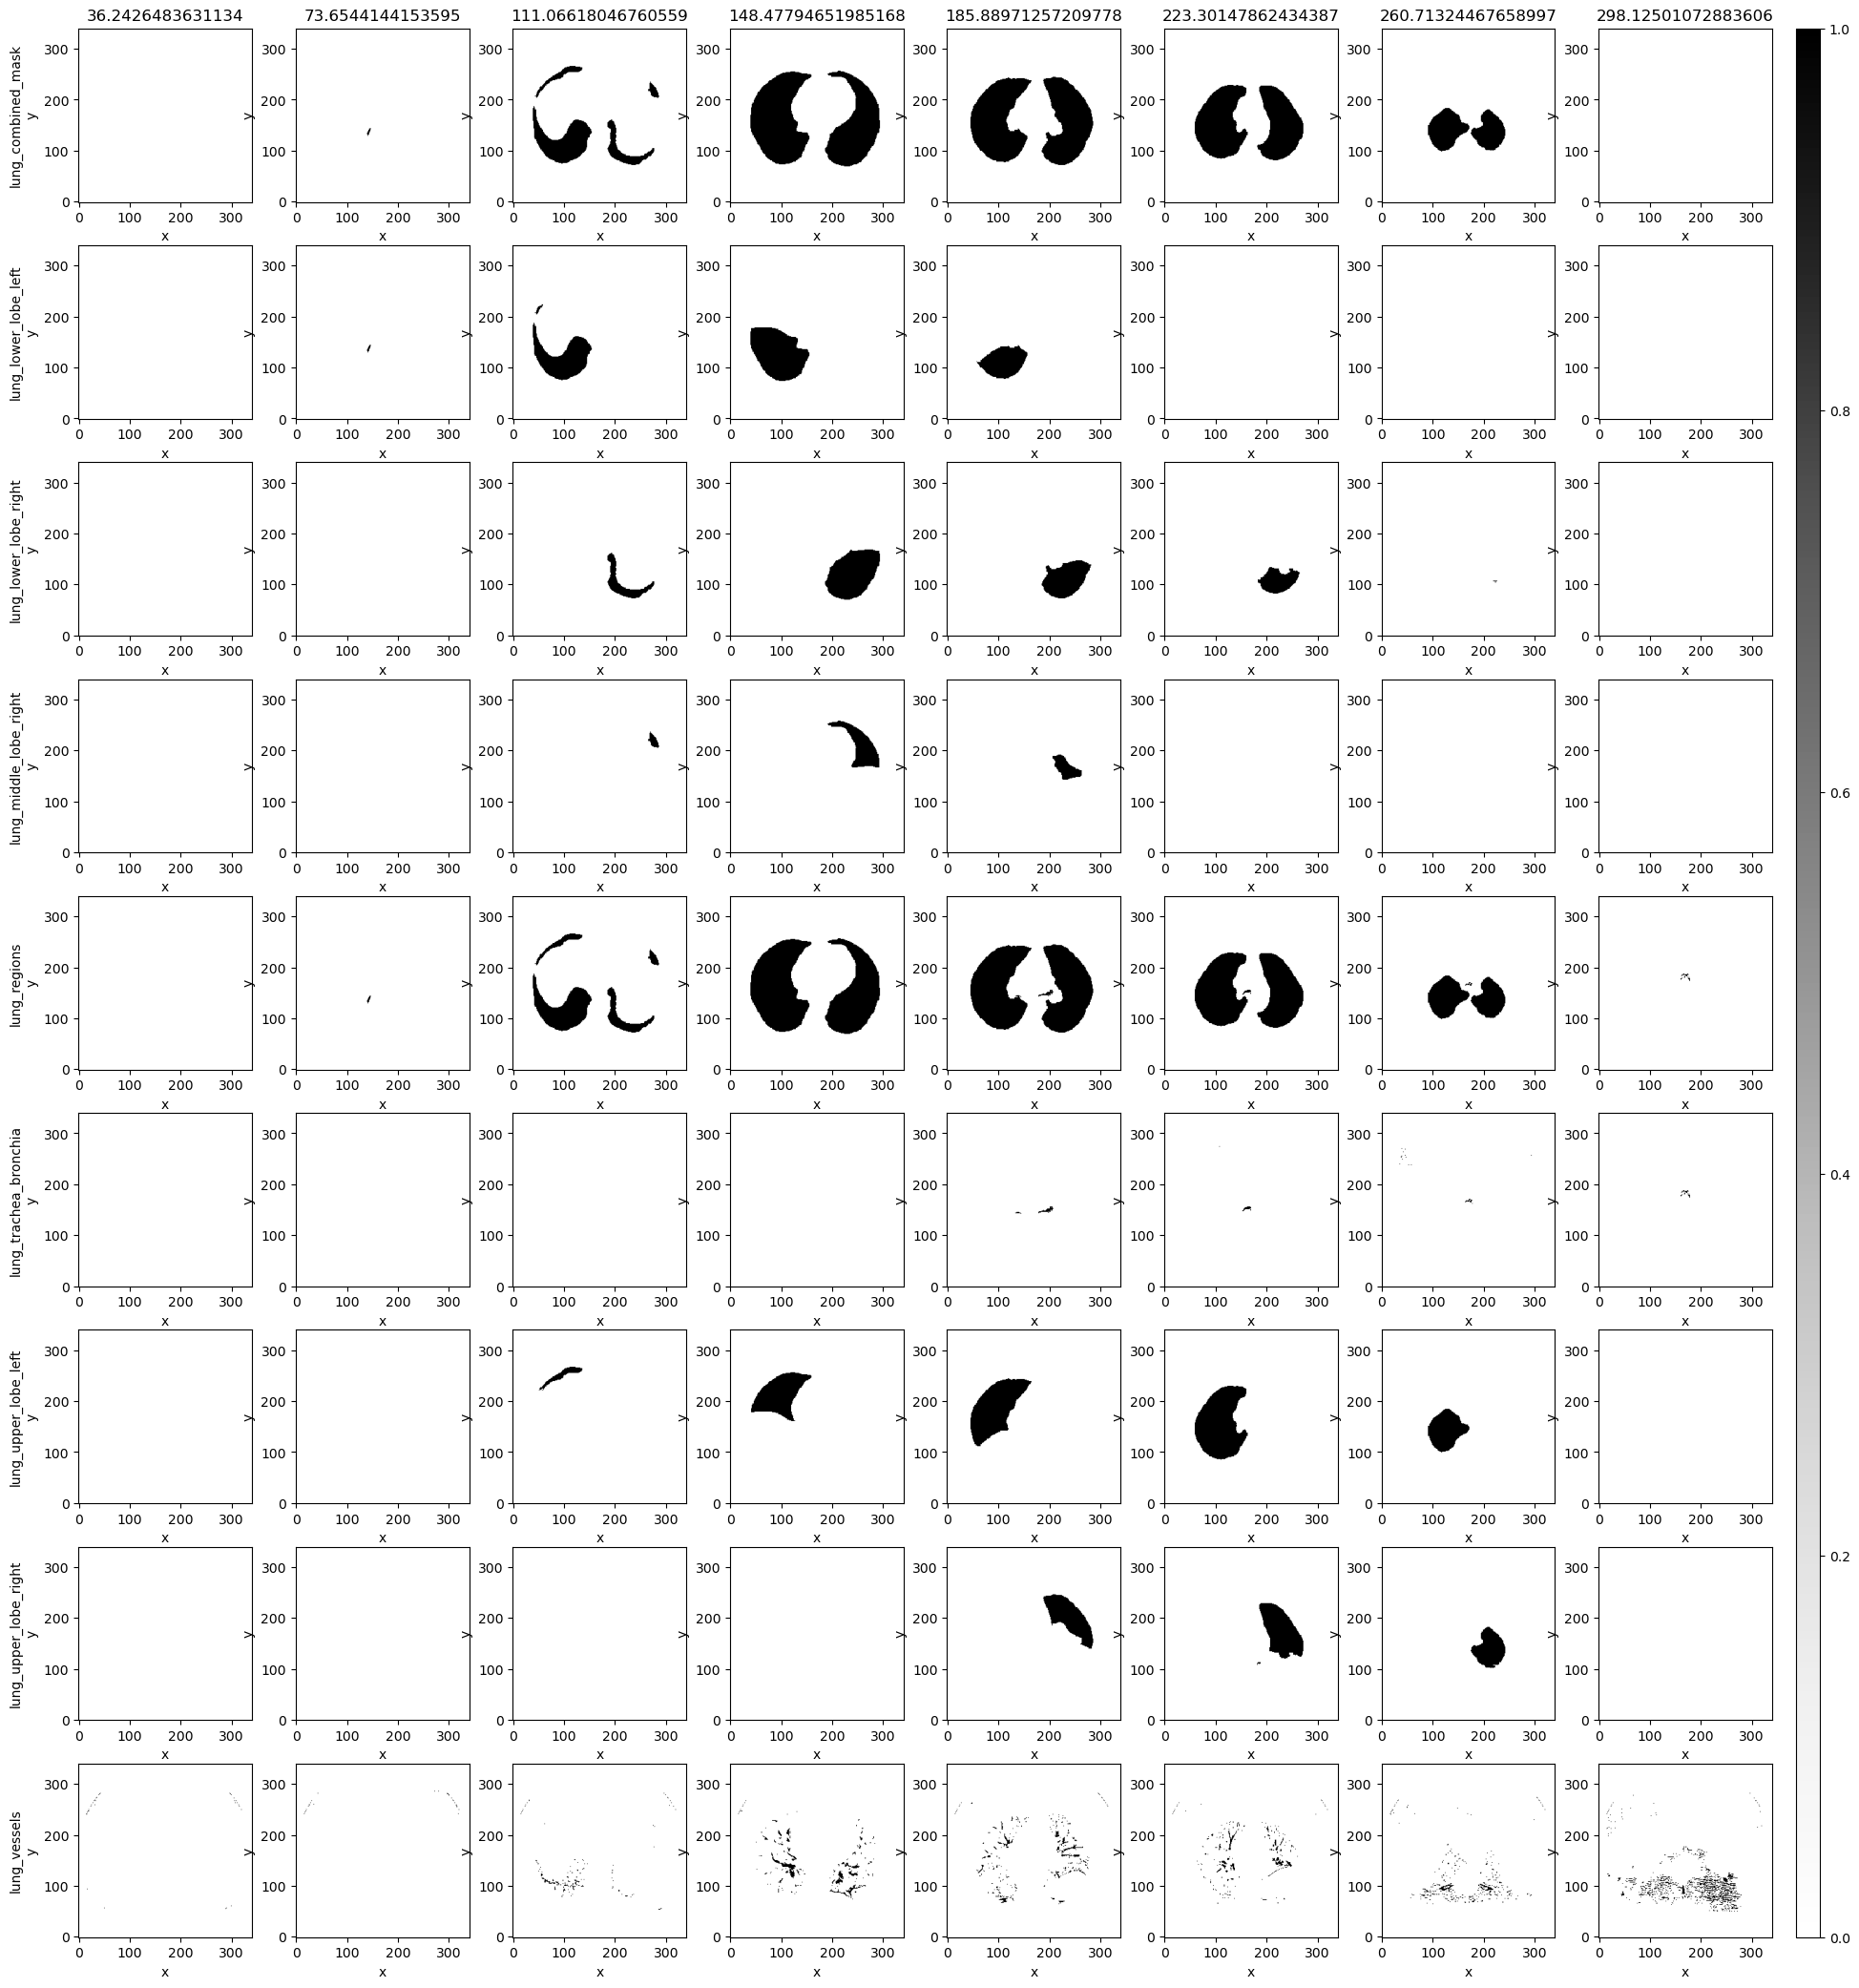

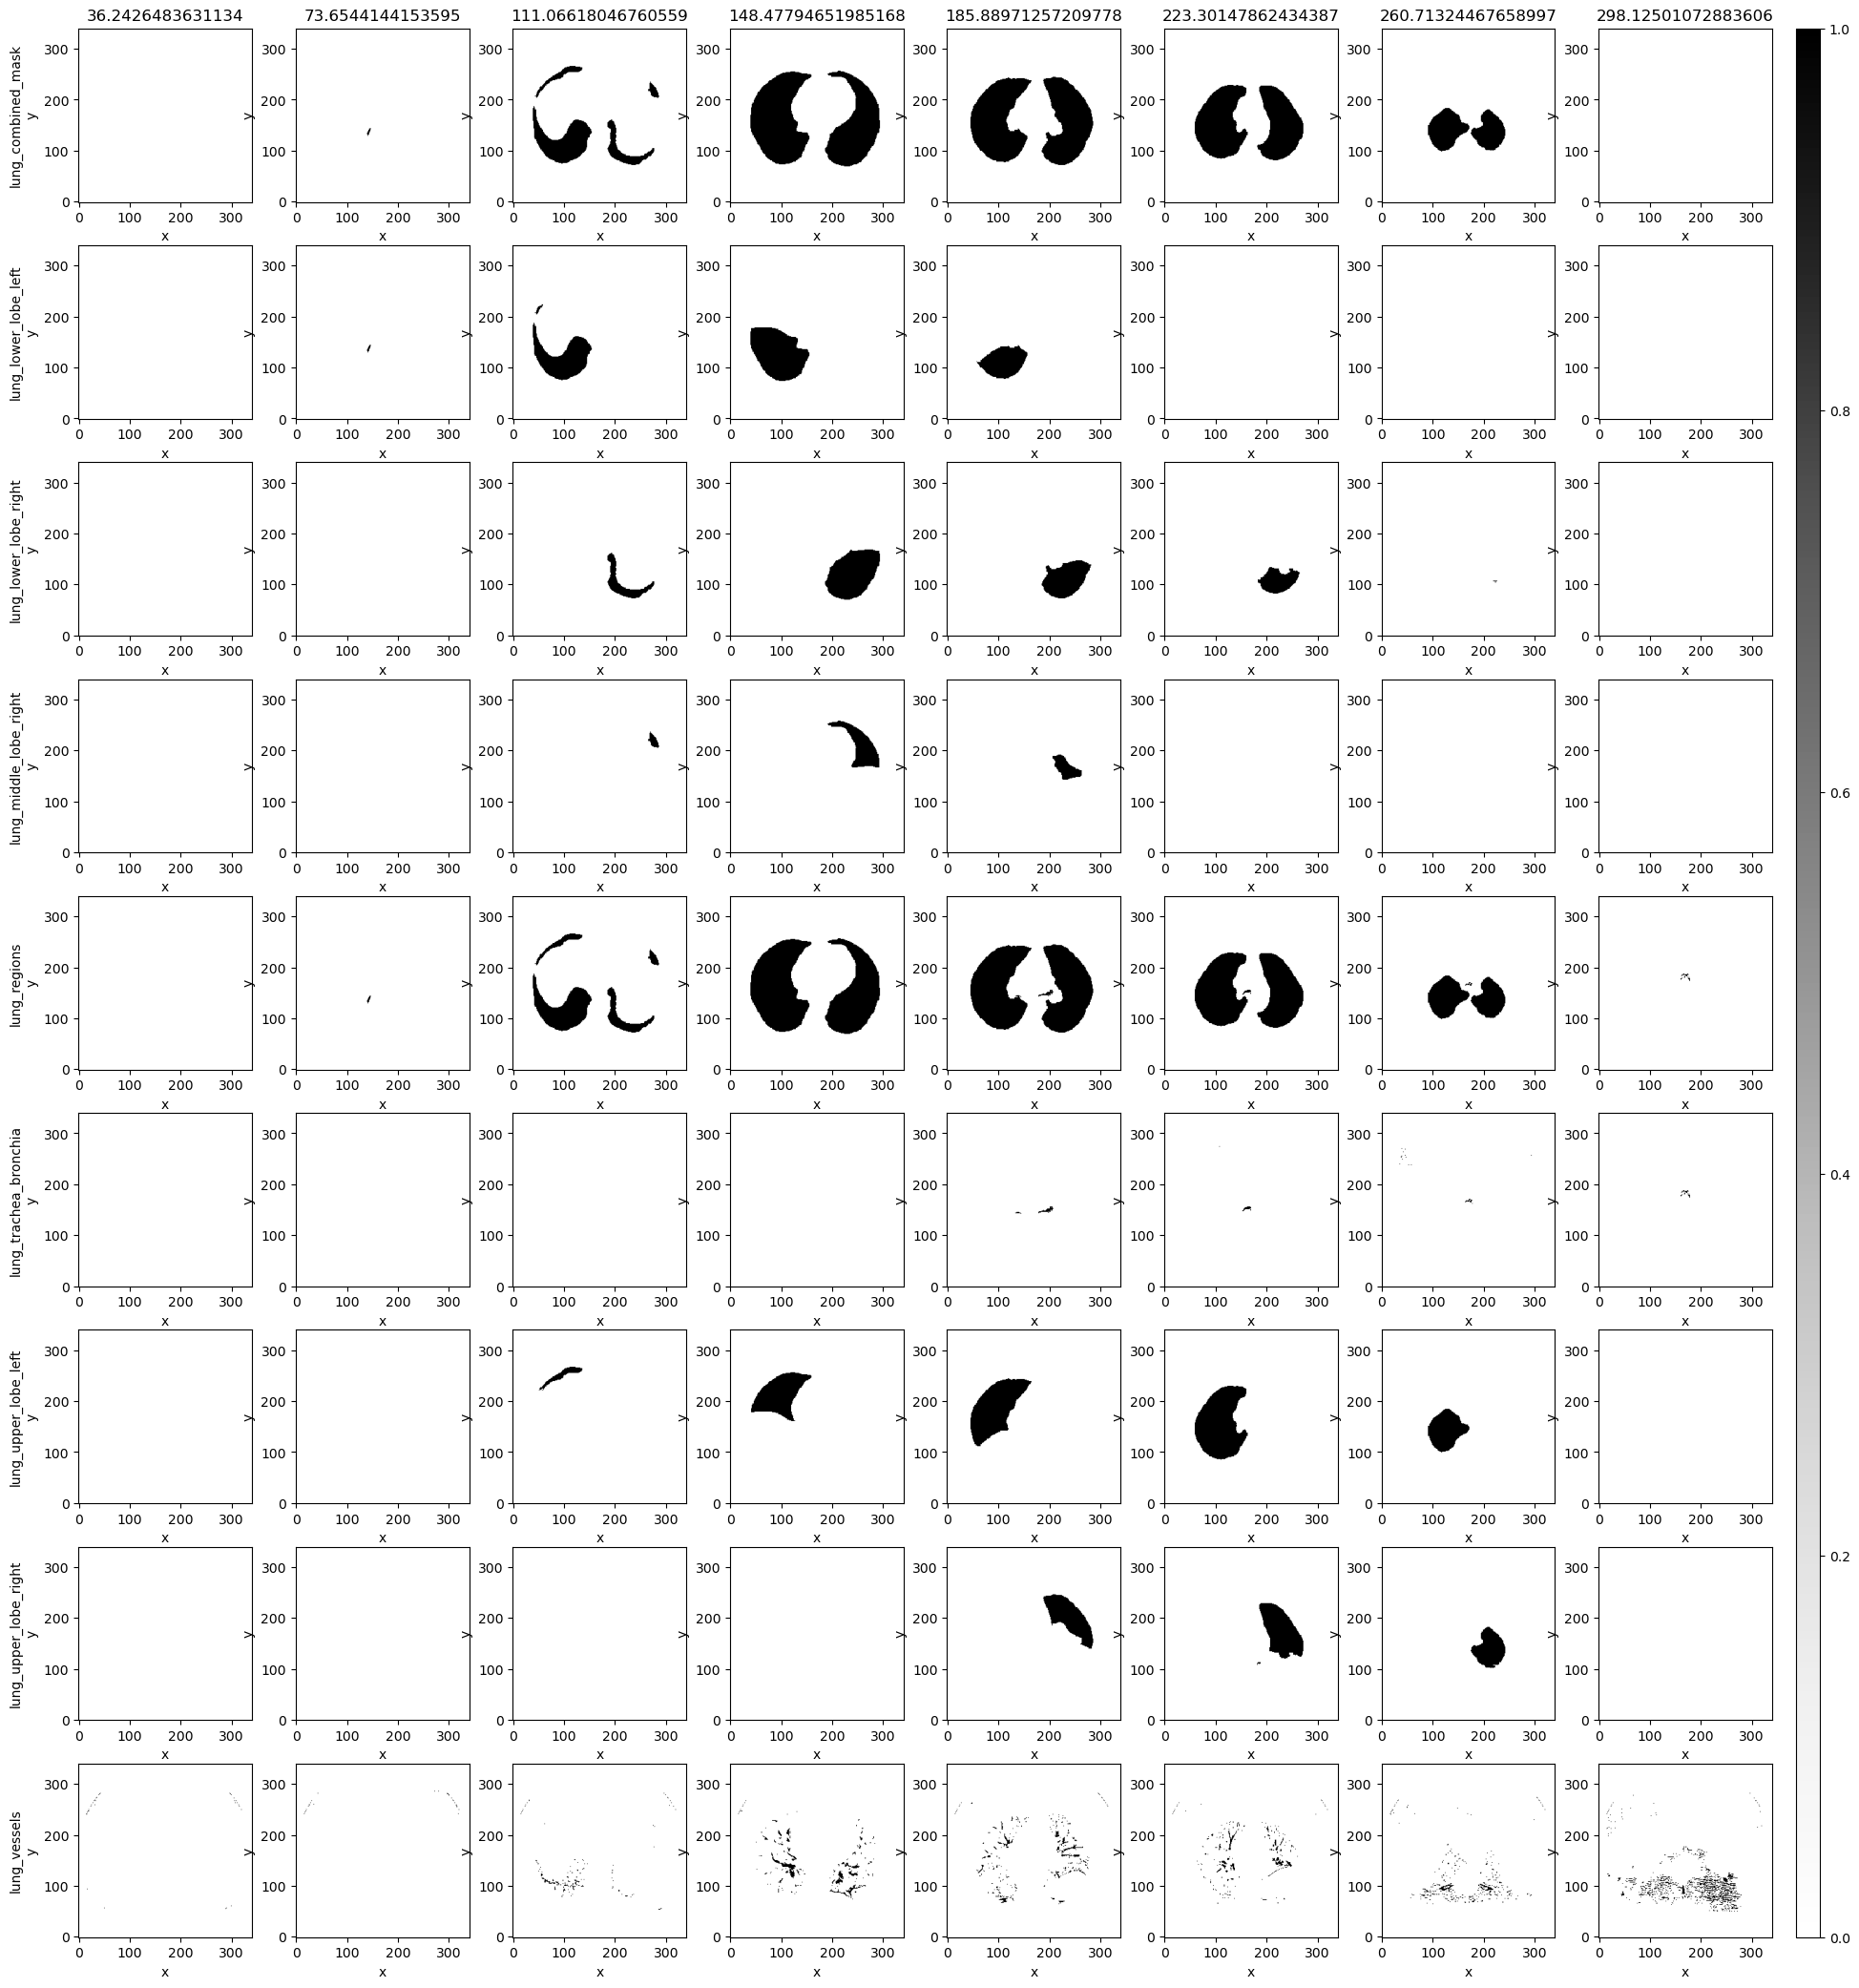

In [20]:
xview(masks[0][:,:,:,31::32], cmap='Greys', vmin=0, vmax=1, row='roi', col='z', ax_height=2, ax_width=2, space=0.25)

In [21]:
%%time
def clean_totalsegmentator_masks(visit, image_name, mask_dir):
    assert all_task_rois[-1] == 'lung_vessels'

    print('Postprocessing segmentation masks')
    region_data = []
    for i, roi in enumerate(all_task_rois):
        mask_file = visit.mask_file(mask_dir, image_name, roi)
        
        print(f'Cleaning {mask_file}')
        mask_nifti = nib.load(mask_file)
        mask_data = mask_nifti.get_fdata()
        
        if roi != 'lung_vessels':
            new_mask_data = mask_data #select_regions_by_size(mask, n_regions=2)
    
        else: # lung_vessels
            new_mask_data = mask_data.astype(bool)
            new_mask_data |= skimage.morphology.skeletonize(mask_data)
            new_mask_data &= (np.stack(region_data).sum(axis=0) > 0)
            new_mask_data = select_regions_by_size(new_mask_data.astype(float), n_regions=2)
        
        region_data.append(new_mask_data * (i + 1))
    
    # combine into single region mask
    region_data = np.stack(region_data).max(axis=0)

    region_file = visit.mask_file(mask_dir, image_name, roi='lung_regions')
    print(f'Creating {region_file}')
    region_nifti = nib.nifti1.Nifti1Image(region_data, mask_nifti.affine)
    nib.save(region_nifti, region_file)

    return region_data
          
regions = clean_totalsegmentator_masks(visit, image_name, mask_dir)
regions.shape

Postprocessing segmentation masks
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_upper_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_middle_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_right.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_upper_lobe_left.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz
Cleaning /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_trachea_bronchia.ni

(256, 256, 256)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

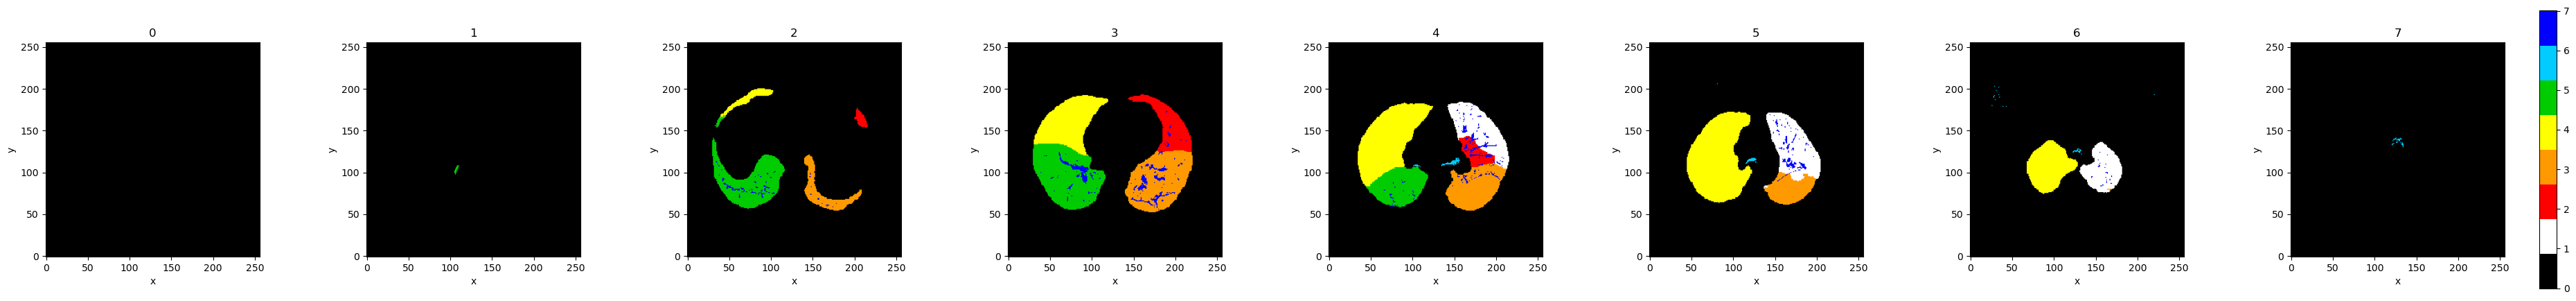

In [22]:
xview(project.utils.as_xarray(regions[:,:,31::32], name='regions', dims=['x', 'y', 'z']), col='z')

In [23]:
%%time
def create_lung_region_mask(visit, image_name, mask_dir, new_roi):
    print(f'Creating lung region mask for subject {visit.subject_id} visit {visit.visit_name} image {image_name}')
    regions = []
    
    lung_file = visit.mask_file(mask_dir, image_name, roi='lung_combined_mask')
    lung_nifti = nib.load(lung_file)
    lung_mask = lung_nifti.get_fdata().astype(bool)
    lung_mask = select_regions_by_size(lung_mask, n_regions=2, min_size=30)
    regions.append(lung_mask)
    
    #lobes_file = case.medpseg_mask_file(phase, roi='lobes')
    #lobes_mask = nib.load(lobes_file).get_fdata().astype(int)
    #for i in range(5):
    #    lobe_mask = select_regions_by_size(lobes_mask == (i+1), n_regions=1)
    #    regions.append(lobe_mask * (i+1))
    
    airway_file = visit.mask_file(mask_dir, image_name, roi='lung_trachea_bronchia')
    airway_mask = nib.load(airway_file).get_fdata().astype(bool)
    airway_mask = select_regions_by_size(airway_mask, n_regions=1)
    regions.append(airway_mask * 6)
    
    vessel_file = visit.mask_file(mask_dir, image_name, roi='lung_vessels')
    vessel_mask = nib.load(vessel_file).get_fdata().astype(bool)
    vessel_mask |= skimage.morphology.skeletonize(vessel_mask)
    vessel_mask &= (lung_mask | airway_mask)
    regions.append(vessel_mask * 7)
    
    regions_file = visit.mask_file(mask_dir, image_name, roi=new_roi)
    print(f'Saving {regions_file}')
    regions = np.stack(regions).max(axis=0).astype(np.uint16)
    regions_nifti = nib.nifti1.Nifti1Image(regions, lung_nifti.affine)
    nib.save(regions_nifti, regions_file)
    
    return regions

regions = create_lung_region_mask(visit, image_name, mask_dir, new_roi='lung_regions')

Creating lung region mask for subject 10009Y visit Phase-1 image 10009Y_EXP_SHARP_NJC_COPD
[56.7  0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 43.1]
3794 voxels were dropped, 1551207 are left (0.2% dropped)
[ 0.5  0.   0.   0.   0.   0.   0.1  0.   0.1  0.   0.   0.   0.   0.
  0.   0.1  0.1  0.   0.1  0.   0.   0.   0.1  0.1  0.2  0.   0.1  0.1
  0.1  0.   0.   0.1  0.2  0.   0.   0.   0.1  0.   0.2  0.1  0.   0.1
  0.1  0.   0.2  0.   0.1  0.   0.   0.1  0.   0.1  0.   0.5  0.   0.
  1.   0.1  0.   0.   0.   0.5  0.3  0.1  0.   0.2  0.   0.   0.   0.1
  0.   0.3  0.   0.1  0.   0.   0.   0.1  0.   0.2  0.1  0.   0.1  0.
  0.   0.   0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.2  0.1  0.   0.1  0.   0.   0.1  0.   0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  89.8  0.   0.   0.   0.   0.1  0.   0.   0.1  0.
  0.2  0.1  0.   0.   0.   0.1  0.   0.   0.   0.1  0.   0.1  0.   0.1

interactive(children=(Output(),), _dom_classes=('widget-interact',))

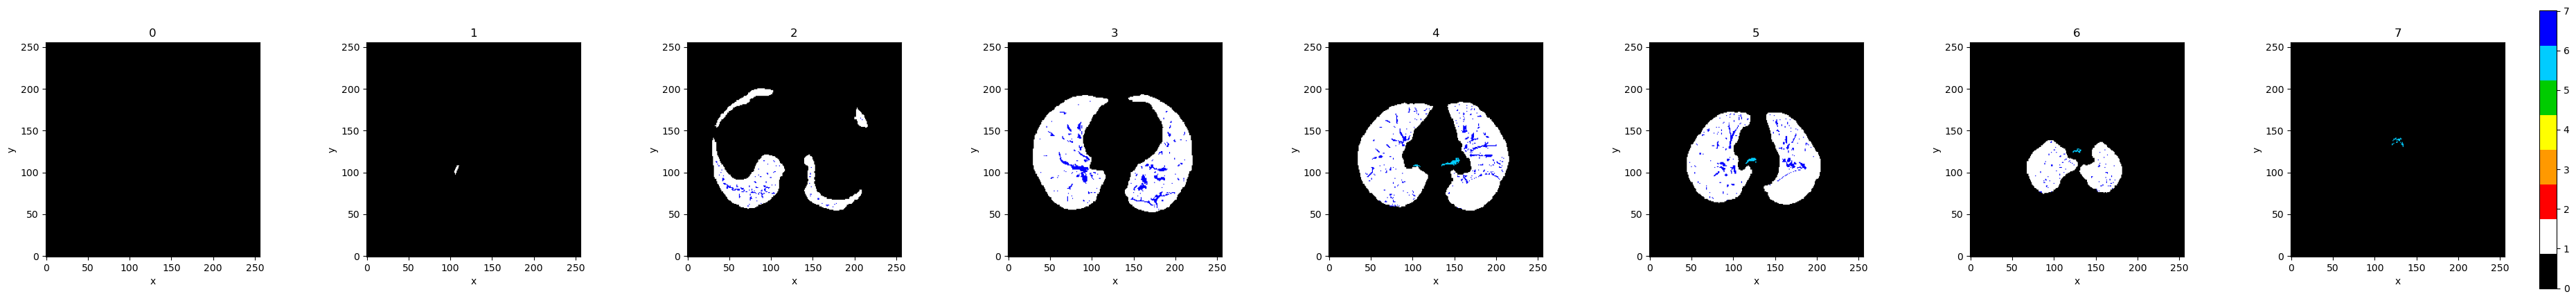

In [24]:
xview(project.utils.as_xarray(regions[:,:,31::32], name='regions', dims=['x', 'y', 'z']), col='z')

In [26]:
%autoreload
def generate_anatomical_mesh(visit, image_name, mask_roi, mesh_version, mask_dir, mesh_dir):
    
    mask_file = visit.mask_file(mask_dir, image_name, mask_roi)
    mask_nifti = nib.load(mask_file)
    mask = mask_nifti.get_fdata()
    resolution = mask_nifti.header.get_zooms()
    print(resolution)

    print('Generating mesh with pygalmesh')
    mesh = pygalmesh.generate_from_array(
        mask.astype(np.uint16),
        voxel_size=resolution,
        max_cell_circumradius={
            'default': 10.0,
            6: 5.0, # airways
            7: 2.0, # vessels
        },
        max_facet_distance=1.5,
        lloyd=True,
        odt=True
    )
    print('Postprocessing mesh')
    mesh = project.meshing.remove_unused_points(mesh)

    tetra_cells = mesh.get_cells_type('tetra')
    mesh.cells = [meshio.CellBlock('tetra', tetra_cells)]
    
    visit.mesh_dir(mesh_dir, image_name).mkdir(exist_ok=True, parents=True)
    mesh_file = visit.mesh_file('pygalmesh', image_name, mask_roi, mesh_version)
    print(f'Saving {mesh_file}')
    meshio.xdmf.write(mesh_file, mesh)

    mesh, cell_labels = project.meshing.load_mesh_fenics(mesh_file)  
    return mesh

generate_anatomical_mesh(visit, image_name, mask_roi='lung_regions', mesh_version=10, mask_dir=mask_dir, mesh_dir=mesh_dir)

(1.3307282, 1.3307282, 1.1691177)
Generating mesh with pygalmesh
Postprocessing mesh
Saving /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/pygalmesh/10009Y_EXP_SHARP_NJC_COPD/lung_regions_10.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10009Y/Phase-1/pygalmesh/10009Y_EXP_SHARP_NJC_COPD/lung_regions_10.xdmf... 18659


```






```

In [34]:
%%time
validate_only = True

for i, subject in enumerate(dataset.subjects):
    for j, visit in enumerate(subject.visits):
        for k, image_name in enumerate(visit.list_images('Resized')):
            print((i,j,k), visit.subject_id, visit.visit_name, image_name)
            if validate_only:
                assert visit.image_file(image_dir, image_name).exists()
                assert visit.mask_file(mask_dir, image_name, roi='lung_combined_mask').exists()
                assert visit.mask_file(mask_dir, image_name, roi='lung_regions').exists()
                assert visit.mesh_file(mesh_dir, image_name, mask_roi='lung_regions',  mesh_version=10).exists()
            else:
                run_totalsegmentator_tasks(visit, image_name, image_dir, mask_dir)
                regions = create_lung_region_mask(visit, image_name, mask_dir, new_roi='lung_regions')
                mesh = generate_anatomical_mesh(
                    visit, image_name, mask_roi='lung_regions', mesh_version=10, mask_dir=mask_dir, mesh_dir=mesh_dir
                )


(0, 0, 0) 10009Y Phase-1 10009Y_EXP_SHARP_NJC_COPD
(0, 0, 1) 10009Y Phase-1 10009Y_EXP_STD_NJC_COPD
(0, 0, 2) 10009Y Phase-1 10009Y_INSP_SHARP_NJC_COPD
(0, 0, 3) 10009Y Phase-1 10009Y_INSP_STD_NJC_COPD
(1, 0, 0) 10028C Phase-1 10028C_EXP_SHARP_NJC_COPD
(1, 0, 1) 10028C Phase-1 10028C_EXP_STD_NJC_COPD
(1, 0, 2) 10028C Phase-1 10028C_INSP_SHARP_NJC_COPD
(1, 0, 3) 10028C Phase-1 10028C_INSP_STD_NJC_COPD
(2, 0, 0) 10090H Phase-1 10090H_EXP_SHARP_NJC_COPD
(2, 0, 1) 10090H Phase-1 10090H_EXP_STD_NJC_COPD
(2, 0, 2) 10090H Phase-1 10090H_INSP_SHARP_NJC_COPD
(2, 0, 3) 10090H Phase-1 10090H_INSP_STD_NJC_COPD
(3, 0, 0) 10161E Phase-1 10161E_EXP_SHARP_NJC_COPD
(3, 0, 1) 10161E Phase-1 10161E_EXP_STD_NJC_COPD
(3, 0, 2) 10161E Phase-1 10161E_INSP_SHARP_NJC_COPD
(3, 0, 3) 10161E Phase-1 10161E_INSP_STD_NJC_COPD
(4, 0, 0) 10171H Phase-1 10171H_EXP_SHARP_NJC_COPD
(4, 0, 1) 10171H Phase-1 10171H_EXP_STD_NJC_COPD
(4, 0, 2) 10171H Phase-1 10171H_INSP_SHARP_NJC_COPD
(4, 0, 3) 10171H Phase-1 10171H_INSP_STD

In [37]:
dataset[1][0].list_images(image_dir)

['10028C_EXP_SHARP_NJC_COPD',
 '10028C_EXP_STD_NJC_COPD',
 '10028C_INSP_SHARP_NJC_COPD',
 '10028C_INSP_STD_NJC_COPD']

In [40]:
dataset[1][0].list_masks(mask_dir, '10028C_EXP_SHARP_NJC_COPD')

['lung_combined_mask',
 'lung_lower_lobe_left',
 'lung_lower_lobe_right',
 'lung_middle_lobe_right',
 'lung_regions',
 'lung_trachea_bronchia',
 'lung_upper_lobe_left',
 'lung_upper_lobe_right',
 'lung_vessels']

In [4]:
data_root

NameError: name 'data_root' is not defined